# Use map to generate tasks dynamically

The `active_map_zone` in WorkGraph is conceptually similar to Python's built-in map function. In WorkGraph, the `active_map_zone` spawns the tasks in the WorkGraph for each item in a dataset.

### Why use `active_map_zone`?

- **Creates dynamic tasks**: The number of tasks is determined at runtime based on input size.
- **Encapsulates child tasks**: All tasks inside a `active_map_zone` block are executed independently for each input item.

## Example: Running Tasks in Parallel with `active_map_zone`

Let's consider a simple workflow where we:
1. Generate a dictionary of numbers.
2. Add 1 to each number.
3. Multiply the result by 2.


In [1]:
from aiida_workgraph import task, WorkGraph, active_map_zone
from aiida import load_profile, orm

load_profile()

@task.calcfunction(outputs=["result"])
def generate_data(n: int) -> dict:
    """Generate a dictionary of integers."""
    result = {f"key_{i}": orm.Int(i) for i in range(n.value)}
    return {"result": result}

@task.calcfunction()
def add(x, y):
    return x + y

@task.calcfunction()
def multiply(x, y):
    return x * y

n = 3
with WorkGraph("map_example_1") as wg:
    data = generate_data(n=n)
    with active_map_zone(data) as map_zone:
        result = add(x=map_zone.item, y=1)
        result = multiply(x=result, y=2)

# Show the WorkGraph
wg.to_html()
# wg


### 🔹 What happens here?
- `active_map_zone` **automatically applies** the tasks (`add1` and `multiply2`) to **each element** in the dictionary output of `generate_data`.
- Each instance of `add1` and `multiply2` **runs independently and in parallel**.
- The `map_zone.item` is a special reference that **ensures each element is mapped correctly**.


### Running and Checking Results


In [2]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))

03/26/2025 09:24:19 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61657|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data1
03/26/2025 09:24:20 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61657|WorkGraphEngine|update_task_state]: Task: generate_data1, type: CALCFUNCTION, finished.
03/26/2025 09:24:20 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61657|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_zone2
03/26/2025 09:24:20 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61657|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add3,key_1_add3,key_2_add3
03/26/2025 09:24:20 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61657|WorkGraphEngine|update_task_state]: Task: key_0_add3, type: CALCFUNCTION, finished.
03/26/2025 09:24:20 PM <761089> aiida.orm.nodes.process.workflow.work

State of WorkGraph:   FINISHED


Generate node graph from the AiiDA process:

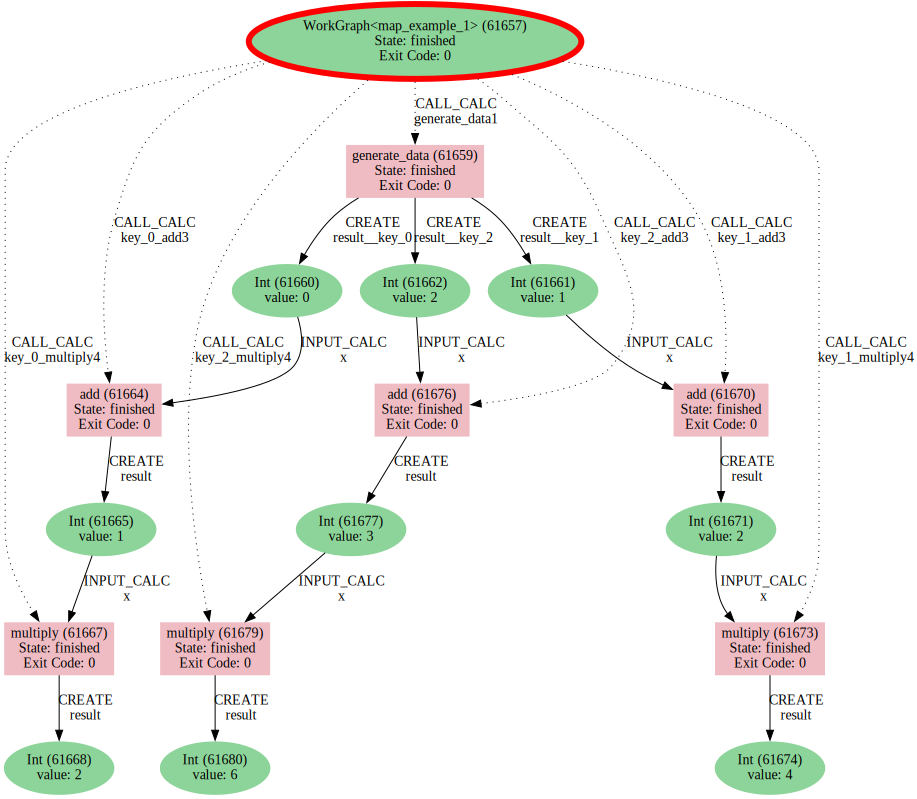

In [3]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` tasks and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [4]:
@task.calcfunction()
def calc_sum(**datas) -> dict:
    """Compute the sum of all provided values."""
    return  sum(datas.values())

n = 3
with WorkGraph("map_example_1") as wg:
    data = generate_data(n=n)
    with active_map_zone(data) as map_zone:
        result = add(x=map_zone.item, y=1)
        result = multiply(x=result, y=2)
    total = calc_sum(datas=result)
wg.to_html()


Run the workgraph and get the result of the tasks:

In [5]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))
print('Result of task add1: {}'.format(total.value))

03/26/2025 09:24:24 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61681|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data1
03/26/2025 09:24:24 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61681|WorkGraphEngine|update_task_state]: Task: generate_data1, type: CALCFUNCTION, finished.
03/26/2025 09:24:24 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61681|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_zone2
03/26/2025 09:24:25 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61681|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add3,key_1_add3,key_2_add3
03/26/2025 09:24:26 PM <761089> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61681|WorkGraphEngine|update_task_state]: Task: key_0_add3, type: CALCFUNCTION, finished.
03/26/2025 09:24:26 PM <761089> aiida.orm.nodes.process.workflow.work

State of WorkGraph:   FINISHED
Result of task add1: uuid: d9e4d2c2-dd45-4834-871b-56ae6572be96 (pk: 61706) value: 12


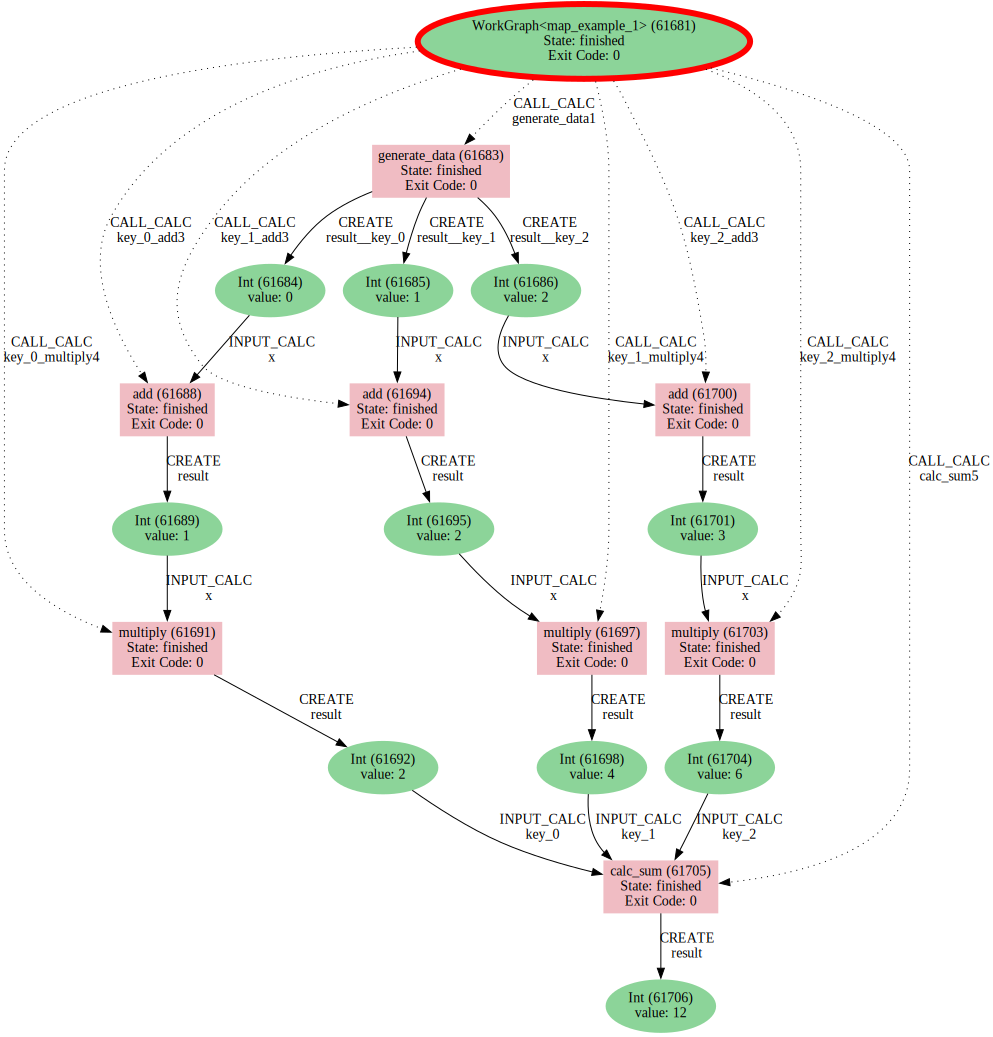

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

You can see that the outputs of all `add` tasks are linked to the input of the `calc_sum` task.